In [1]:
import urllib.request
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [2]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/mohitgupta-omg/Kaggle-SMS-Spam-Collection-Dataset-/master/spam.csv", filename="data/spam.csv")
data = pd.read_csv('data/spam.csv', encoding='latin-1')

In [3]:
data.shape

(5572, 5)

In [4]:
data.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [5]:
del data['Unnamed: 2']
del data['Unnamed: 3']
del data['Unnamed: 4']
data['v1'] = data['v1'].replace(['ham','spam'],[0,1])
data.head()

,v1,v2
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


In [6]:
data['v1'].nunique(), data['v2'].nunique()

(2, 5169)

In [7]:
data.drop_duplicates(subset=['v2'], inplace=True)
data.shape

(5169, 2)

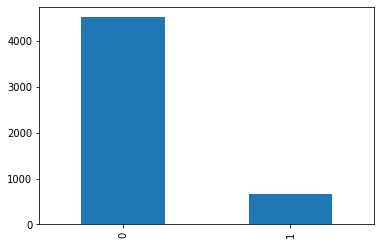

In [8]:
data['v1'].value_counts().plot(kind='bar')

In [11]:
print(data.groupby('v1').size().reset_index(name='count'))

   v1  count
0   0   4516
1   1    653


In [12]:
X_data = data['v2']
y_data = data['v1']

In [13]:
vocab_size = 1000
tokenizer = Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(X_data)
sequences = tokenizer.texts_to_sequences(X_data)

In [14]:
sequences[:2]

[[47, 433, 780, 705, 662, 64, 8, 94, 121, 434, 142, 68, 57, 137],
 [49, 306, 435, 6]]

In [15]:
n_of_train = int(len(sequences)*0.8)
n_of_test = int(len(sequences) - n_of_train)
print(n_of_train, n_of_test)

4135 1034


메일의 최대 길이 : 172
메일의 평균 길이 : 12


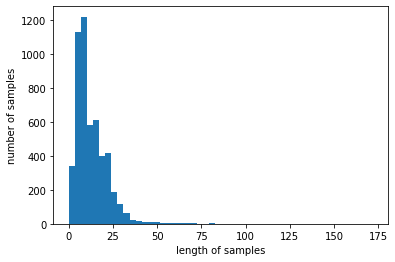

In [16]:
X_data = sequences
print('메일의 최대 길이 : %d' %max(len(l) for l in X_data))
print('메일의 평균 길이 : %d' %(sum(map(len, X_data))/ len(X_data)))
plt.hist([len(s) for s in X_data], bins = 50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [17]:
max_len =172
data = pad_sequences(X_data, maxlen = max_len)
print(data.shape)

(5169, 172)


In [18]:
X_test = data[n_of_train:]
y_test = np.array(y_data[n_of_train:])

X_train = data[:n_of_train]
y_train = np.array(y_data[:n_of_train])

print("훈련용 이메일 데이터의 크기(shape): ", X_train.shape)
print("테스트용 이메일 데이터의 크기(shape): ", X_test.shape)
print("훈련용 레이블의 크기(shape): ", y_train.shape)
print("테스트용 레이블의 크기(shape): ", y_test.shape)

훈련용 이메일 데이터의 크기(shape):  (4135, 172)
테스트용 이메일 데이터의 크기(shape):  (1034, 172)
훈련용 레이블의 크기(shape):  (4135,)
테스트용 레이블의 크기(shape):  (1034,)


In [20]:
from tensorflow.keras.layers import Dense, Conv1D, GlobalMaxPooling1D, Embedding, Dropout, MaxPooling1D 
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [22]:
model = Sequential()
model.add(Embedding(vocab_size, 32))
model.add(Dropout(0.2))
model.add(Conv1D(32, 5, strides=1, padding='valid', activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))
model.summary()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 32)          32000     
_________________________________________________________________
dropout_2 (Dropout)          (None, None, 32)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 32)          5152      
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                2112      
_________________________________________________________________
dropout_3 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                

In [23]:
es = EarlyStopping(monitor = 'val_loss', mode= 'min', verbose=1, patience=3)
mc = ModelCheckpoint('model/1d_cnn_spam.h5', monitor='val_acc', mode='max', verbose=1,save_best_only=True)

In [24]:
history= model.fit(X_train, y_train, epochs=10, batch_size=64, validation_split=0.2, callbacks=[es, mc])

Epoch 1/10
47/52 [==========================>...] - ETA: 0s - loss: 0.4985 - acc: 0.8261
Epoch 00001: val_acc improved from -inf to 0.87304, saving model to model/1d_cnn_spam.h5
52/52 [==============================] - 1s 11ms/step - loss: 0.4896 - acc: 0.8304 - val_loss: 0.3792 - val_acc: 0.8730
Epoch 2/10
50/52 [===========================>..] - ETA: 0s - loss: 0.3851 - acc: 0.8706
Epoch 00002: val_acc did not improve from 0.87304
52/52 [==============================] - 0s 8ms/step - loss: 0.3859 - acc: 0.8697 - val_loss: 0.3649 - val_acc: 0.8730
Epoch 3/10
50/52 [===========================>..] - ETA: 0s - loss: 0.2719 - acc: 0.8888
Epoch 00003: val_acc improved from 0.87304 to 0.97461, saving model to model/1d_cnn_spam.h5
52/52 [==============================] - 0s 8ms/step - loss: 0.2670 - acc: 0.8918 - val_loss: 0.1464 - val_acc: 0.9746
Epoch 4/10
51/52 [============================>.] - ETA: 0s - loss: 0.0780 - acc: 0.9789
Epoch 00004: val_acc improved from 0.97461 to 0.98307, 

In [25]:
print("\n 테스트 정확도: %.4f" % (model.evaluate(X_test, y_test)[1]))

33/33 [==============================] - 0s 2ms/step - loss: 0.0678 - acc: 0.9807

 테스트 정확도: 0.9807
